## Import Packages

In [1]:
import cPickle
from functools import partial
from gensim import corpora
import matplotlib.pyplot as plt
from matplotlib import font_manager
from mpl_toolkits.axes_grid1.axes_divider import make_axes_area_auto_adjustable
import multiprocessing
import numpy as np
import os
import pandas as pd

%matplotlib inline

/Users/Trent/anaconda/lib/python2.7/site-packages/gensim/utils.py:1015: UserWarning: Pattern library is not installed, lemmatization won't be available.
  warnings.warn("Pattern library is not installed, lemmatization won't be available.")


## Import Data

In [2]:
filepath = '../data/Top_Traversals_demo-1daybehavior_20140401.csv'
data_df = pd.read_csv(filepath, header = 0)
data_df.head()

,Rank,Sessions,Total Sessions,% of Total Sessions,Paths,% of Total Paths,Path
0,1,792522,4802851,0.165011,792522,0.165011,journey.entry->journey.exit
1,2,413008,4802851,0.085992,413008,0.085992,journey.entry->web.entry->webevent.login->webe...
2,3,283578,4802851,0.059044,283578,0.059044,journey.entry->web.entry->webevent.login->webe...
3,4,241868,4802851,0.050359,241868,0.050359,journey.entry->web.entry->webevent.login->webe...
4,5,180357,4802851,0.037552,180357,0.037552,journey.entry->declined->journey.exit


In [3]:
data_df.shape

(438982, 7)

we have 438,982 rows. The only column we are interested in, however, is the <strong>Path</strong> column.

## Import Model
This is the model that has been trained on all of data_df. The model is a gensim object.

In [4]:
model_filepath = 'word_transition_model/data/ldamodel.pkl'
model = cPickle.load(open(model_filepath, 'r'))
print model

LdaModel(num_terms=17851, num_topics=30, decay=0.5, chunksize=2000)


Below we have the transitions that compose each topic.

In [5]:
model.show_topics(30)

[(0,
  u'0.205*"webevent.login->webevent.view.account.summary.success" + 0.098*"webevent.view.account.summary.success->webevent.view.transactions.and.details.success" + 0.064*"web.entry->webevent.login" + 0.064*"webevent.view.statements.page->webevent.system.retrieve.default.email.address" + 0.055*"webevent.view.transactions.and.details.success->webevent.view.make.a.payment" + 0.053*"web.exit->journey.exit" + 0.046*"webevent.view.account.summary.success->webevent.view.statements.page" + 0.044*"webevent.view.make.a.payment->webevent.login" + 0.041*"journey.entry->web.entry" + 0.027*"webstc.view.rewards.summary->webevent.view.transactions.and.details.success"'),
 (1,
  u'0.161*"webevent.view.make.a.payment->webevent.view.payment.activity" + 0.144*"webevent.login->webevent.view.account.summary.success" + 0.115*"webevent.view.payment.activity->webevent.make.a.payment.success" + 0.078*"web.entry->webevent.login" + 0.078*"webevent.view.account.summary.success->webevent.view.make.a.payment" +

## Make Predictions for Journeys
The three functions defined below allow us to make predictions on journeys.

In [6]:
def format_input_string(input_string):
    #INPUT: string in format of original journey csv
    #OUTPUT: string formatted like "event->event event2->event2 etc."
    string_list = input_string.replace(' ', '.').replace('->', ' ').split()
    zip_list = zip(string_list, string_list[1:])
    formatted_list = [val[0] + '->' + val[1] for val in zip_list]
    return formatted_list

def predict_text(formatted_list, model):
    #INPUT: journey to predit in list of strings format.
    #The journey will have to be
    #formatted like ['event->event', 'event2->event2']
    #OUTPUT: model predictions for input
    text = [formatted_list]
    dictionary = corpora.Dictionary(text)
    corpus = [dictionary.doc2bow(phrase) for phrase in text]
    return model.get_document_topics(corpus[0], minimum_probability = .05)

def make_results_df(string_list, model):
    #INPUT: list of strings to be converted and predicts
    #OUTPUT: dataframe of strings and predictions
    df = pd.DataFrame(columns=['Journey', 'Prediction'])
    for string in string_list:
        formatted_list = format_input_string(string)
        prediction = predict_text(formatted_list, model)
        df = df.append({'Journey': string, 'Prediction': prediction}, ignore_index = True)
    return df

<br><br><br>Below is a list of cluster predictions for the top 10 journeys. The cluster number precedes the probability of the cluster given the sentence. You can see the top transitions associated with each cluster above in the model.show_topics(30) output.

In [7]:
predictions = pd.read_csv('word_transition_model/data/predictions.csv')
predictions.head(10)

,Unnamed: 0,Journey,Prediction
0,0,journey.entry->journey.exit,"[(28, 0.51666666666666672)]"
1,1,journey.entry->web.entry->webevent.login->webe...,"[(28, 0.83888888888885027)]"
2,2,journey.entry->web.entry->webevent.login->webe...,"[(2, 0.52896700523349849), (28, 0.337699661433..."
3,3,journey.entry->web.entry->webevent.login->webe...,"[(2, 0.38491309107891053), (5, 0.3207125054555..."
4,4,journey.entry->declined->journey.exit,"[(28, 0.67777777777625992)]"
5,5,journey.entry->ivr.entry->ivr.proactive balanc...,"[(28, 0.83888888888884505)]"
6,6,journey.entry->mobile.entry->mobileevent.login...,"[(28, 0.83888888888885049)]"
7,7,journey.entry->web.entry->web.exit->journey.exit,"[(28, 0.7583333333332829)]"
8,8,journey.entry->mobile.entry->mobileevent.login...,"[(28, 0.80666666666661535)]"
9,9,journey.entry->ivr.entry->ivr.proactive balanc...,"[(2, 0.52942281720584339), (28, 0.337243849460..."


## Visualizing the Model's Results

In [8]:
def graph_term_import(df_row, theme_num, word_qty = 50):
    #INPUT: df_row, a row from the output of pandas_visualization
    #INPUT: theme_num, the theme number
    #OUPUT: Horizontal Bar Chart of term import in theme

    #x is labels, y is values
    x = [df_row[i*2+1] for i in range(1, word_qty)]
    y = [float(df_row[i*2]) if str(df_row[i*2]) > '0' else 0 for i in range(1, word_qty)]
    x_pos = np.arange(word_qty-1)
    ticks_font = font_manager.FontProperties(style='normal',
    size=7, weight='normal', stretch='normal')

    fig = plt.figure(figsize = (16,12))
    ax = fig.add_subplot(111)
    ax.barh(x_pos, y, align='center', alpha=0.4)
    ax.set_yticks(x_pos)
    ax.set_yticklabels(x)
    for label in ax.get_yticklabels():
        label.set_fontproperties(ticks_font)

    ax.set_xlabel('Word Probability')
    ax.set_ylabel('Terms')
    ax.set_title('Theme {}'.format(theme_num))
    make_axes_area_auto_adjustable(ax)

Below we see a plot of mobile users using sureswipe.

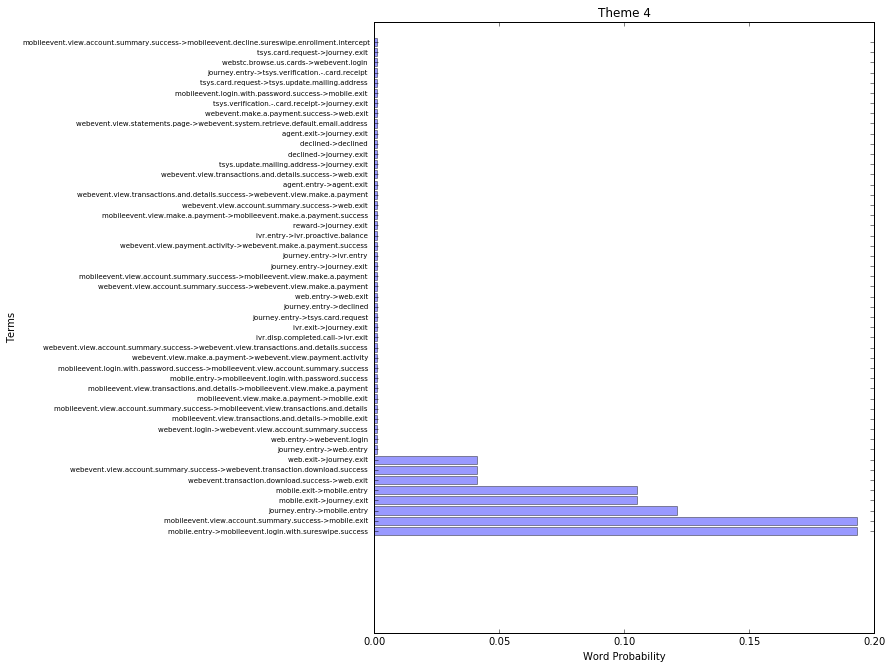

In [9]:
word_df = pd.read_csv('word_transition_model/data/transitions_df.csv')
graph_term_import(word_df.iloc[4, :], 4)